In [1]:
import pandas as pd
import numpy as np

import datetime
import pickle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
df = pd.read_pickle("df_clean")

In [3]:
df.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,operario,Num_Bici_Hist,Duration,Year_Prestamo,Year_Devolucion
0,6501462,18701,1164,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0,161,929.0,978.0,2017,2017
1,6501318,41811,1089,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN,251,1612.0,1908.0,2017,2017
2,6501489,96620,1110,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0,273,1679.0,836.0,2017,2017
3,6501001,16055,1465,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0,273,1076.0,3810.0,2017,2017
4,6501421,6431,996,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN,251,1176.0,1290.0,2017,2017


Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Ver a taxa de ocupação a cada hora

Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?

Quais são as horas/dias da semana/meses mais comuns para usar uma bicicleta?

In [4]:
df.Fecha_Prestamo=pd.to_datetime(df.Fecha_Prestamo)
df.Fecha_Devolucion=pd.to_datetime(df.Fecha_Devolucion)
df['year_prestamo'] = df.Fecha_Prestamo.dt.year
df['month_prestamo'] = df.Fecha_Prestamo.dt.month
df['day_prestamo'] = df.Fecha_Prestamo.dt.day
df['hour_prestamo'] = df.Fecha_Prestamo.dt.hour
df

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,operario,Num_Bici_Hist,Duration,Year_Prestamo,Year_Devolucion,year_prestamo,month_prestamo,day_prestamo,hour_prestamo
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,161,929.0,978.0,2017,2017,2017,6,21,14
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,251,1612.0,1908.0,2017,2017,2017,6,21,14
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,273,1679.0,836.0,2017,2017,2017,6,21,14
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,273,1076.0,3810.0,2017,2017,2017,6,21,13
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,251,1176.0,1290.0,2017,2017,2017,6,21,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10387747,14454800,27944,2369,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,43,541.0,1603.0,2019,2019,2019,12,31,13
10387748,14454778,108800,2393,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,43,715.0,2884.0,2019,2019,2019,12,31,13
10387749,14454793,98449,60,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,83,3497.0,2752.0,2019,2019,2019,12,31,13
10387750,14454774,129665,1829,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,273,534.0,9344.0,2019,2019,2019,12,31,13


In [29]:
def plot_prestamo_over_time(df, time_unit):
    dfYear=df.groupby(time_unit+'_prestamo').size().reset_index(name='count')
    print(dfYear)
    ax = dfYear.plot(x=time_unit+"_prestamo")
    ax.locator_params(integer=True)

   year_prestamo    count
0           2016  1510267
1           2017  2288567
2           2018  2792251
3           2019  3796667


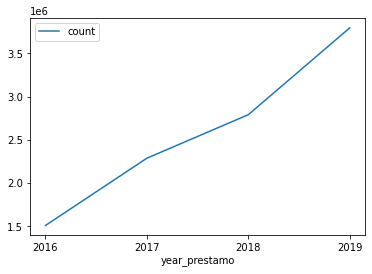

In [31]:
plot_prestamo_over_time(df, "year")

    month_prestamo    count
0                1   667607
1                2   953066
2                3   915511
3                4   752517
4                5   813120
5                6   668363
6                7   844354
7                8  1059919
8                9  1052338
9               10  1065935
10              11   884657
11              12   710365


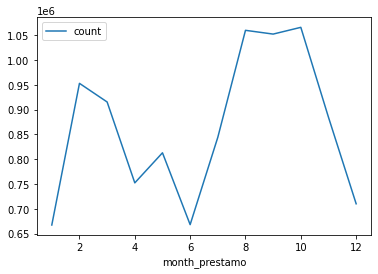

In [32]:
plot_prestamo_over_time(df, "month")

    day_prestamo   count
0              1  297618
1              2  341599
2              3  326286
3              4  338089
4              5  375815
5              6  372006
6              7  309407
7              8  342247
8              9  343406
9             10  344784
10            11  334971
11            12  366040
12            13  346292
13            14  312897
14            15  344659
15            16  359815
16            17  336824
17            18  352997
18            19  337218
19            20  307242
20            21  343125
21            22  363188
22            23  363797
23            24  317759
24            25  331810
25            26  352559
26            27  349052
27            28  339018
28            29  307114
29            30  316946
30            31  213172


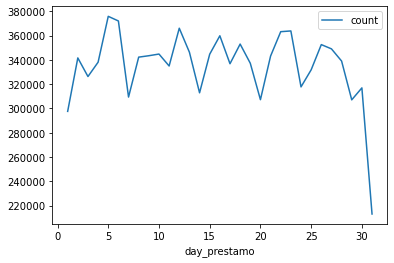

In [33]:
plot_prestamo_over_time(df, "day")

    hour_prestamo    count
0               0        1
1               1        7
2               2        3
3               3        4
4               4     1761
5               5   251400
6               6   601954
7               7   830724
8               8   574668
9               9   608485
10             10   583993
11             11   701674
12             12   761890
13             13   750609
14             14   697095
15             15   677306
16             16   809683
17             17  1060109
18             18   762157
19             19   418370
20             20   287198
21             21     4994
22             22     3652
23             23       15


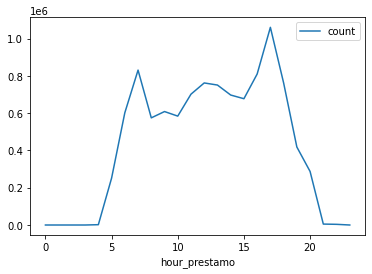

In [30]:
plot_prestamo_over_time(df, "hour")

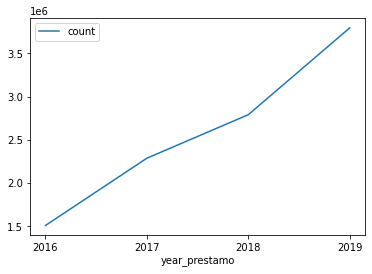

In [ ]:
Quais é que são os tempos médios de empréstimo?


In [23]:
df['duration_hour'] = (df.Fecha_Devolucion-df.Fecha_Prestamo).dt.total_seconds().div(60*60)
df

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,operario,Num_Bici_Hist,Duration,Year_Prestamo,Year_Devolucion,year_prestamo,month_prestamo,day_prestamo,hour_prestamo,duration_minutes,duration_hour
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,161,929.0,978.0,2017,2017,2017,6,21,14,16.300000,0.271667
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,251,1612.0,1908.0,2017,2017,2017,6,21,14,31.800000,0.530000
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,273,1679.0,836.0,2017,2017,2017,6,21,14,13.933333,0.232222
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,273,1076.0,3810.0,2017,2017,2017,6,21,13,63.500000,1.058333
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,251,1176.0,1290.0,2017,2017,2017,6,21,14,21.500000,0.358333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10387747,14454800,27944,2369,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,43,541.0,1603.0,2019,2019,2019,12,31,13,26.716667,0.445278
10387748,14454778,108800,2393,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,43,715.0,2884.0,2019,2019,2019,12,31,13,48.066667,0.801111
10387749,14454793,98449,60,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,83,3497.0,2752.0,2019,2019,2019,12,31,13,45.866667,0.764444
10387750,14454774,129665,1829,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,273,534.0,9344.0,2019,2019,2019,12,31,13,155.733333,2.595556


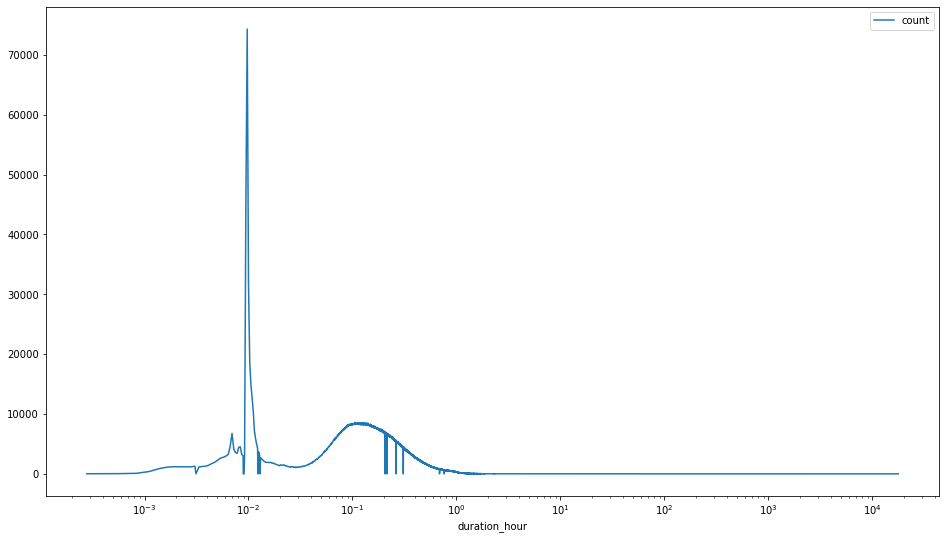

In [25]:
dfDuration=df.groupby('duration_hour').size().reset_index(name='count')
ax=dfDuration.plot(x="duration_hour", y="count", figsize=(16,9))
ax.set_xscale('log')

In [ ]:
Quais as origens/destinos mais comuns?

<AxesSubplot:xlabel='Id_Aparcamiento_Origen'>

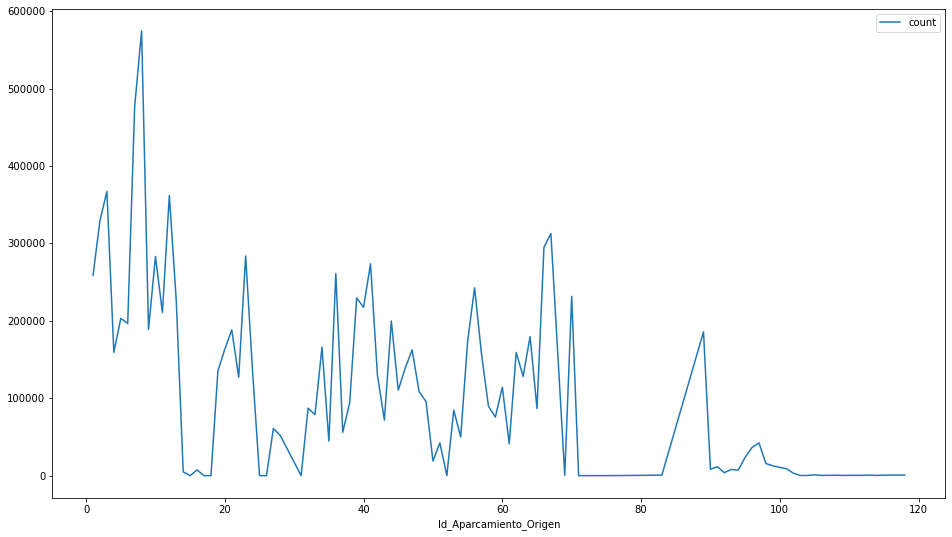

In [29]:
dfOrigin=df.groupby('Id_Aparcamiento_Origen').size().reset_index(name='count')
dfOrigin.plot(x="Id_Aparcamiento_Origen", figsize=(16,9))

<AxesSubplot:xlabel='Id_Aparcamiento_Destino'>

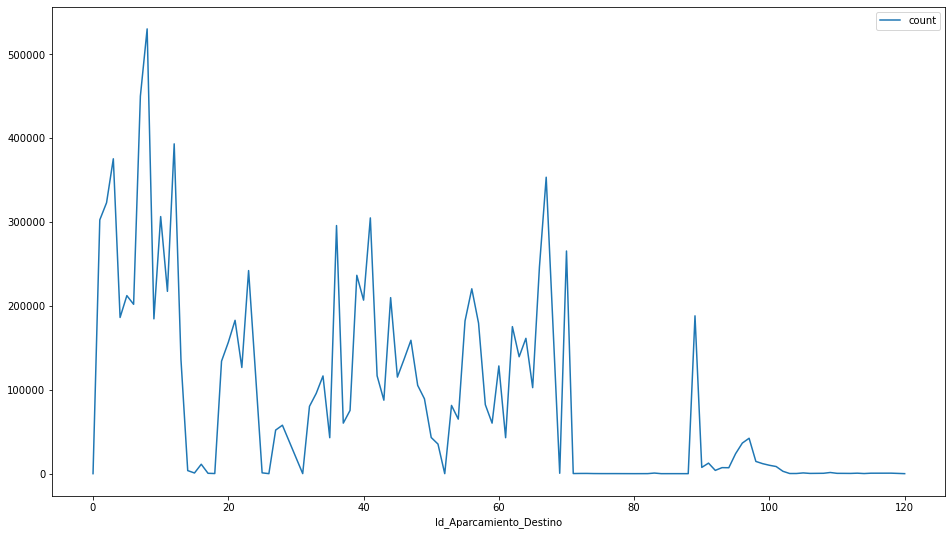

In [30]:
dfDestination=df.groupby('Id_Aparcamiento_Destino').size().reset_index(name='count')
dfDestination.plot(x="Id_Aparcamiento_Destino", figsize=(16,9))

In [ ]:
Quais os trajetos mais comuns?

In [31]:
dfTranjects=df.groupby(['Id_Aparcamiento_Origen', 'Id_Aparcamiento_Destino']).size().reset_index(name='count')
dfTranjects

,Id_Aparcamiento_Origen,Id_Aparcamiento_Destino,count
0,1,1.0,18469
1,1,2.0,62067
2,1,3.0,28127
3,1,4.0,9198
4,1,5.0,674
...,...,...,...
6940,118,112.0,12
6941,118,113.0,18
6942,118,114.0,7
6943,118,115.0,22


<ipython-input-54-fd3694564fd7>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


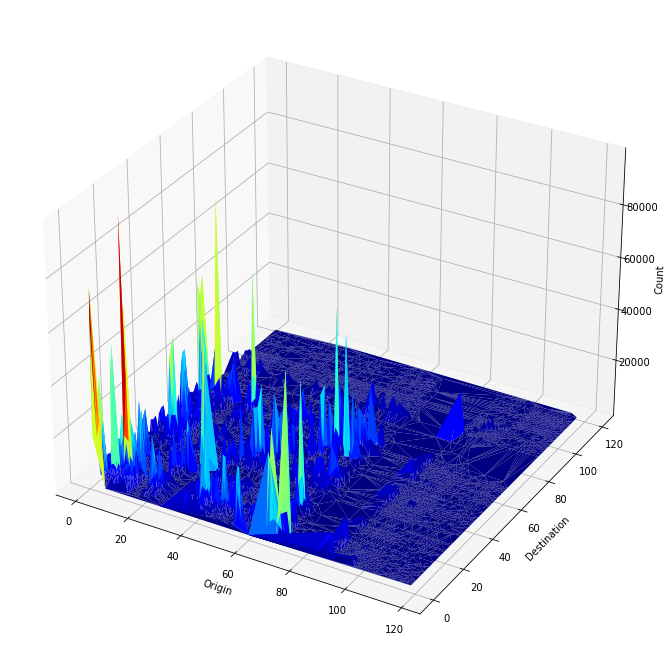

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 9))
ax = Axes3D(fig)

ax.plot_trisurf(dfTranjects["Id_Aparcamiento_Origen"], dfTranjects["Id_Aparcamiento_Destino"], dfTranjects["count"], cmap=cm.jet, linewidth=0.2)
ax.set_zlabel('Count')
ax.set_xlabel('Origin')
ax.set_ylabel('Destination')

plt.show()

In [ ]:
Cadeias de markov ou função matemática: qual é a probabilidade de uma bicicleta ser transportada para uma estação X sabendo que estava na estação Y